## Objective:

The goal of this project is to estimate the impact of marketing channels (TV, digital, print, social media) on weekly product sales, while accounting for seasonality and price fluctuations. My learning intention is to do some simple OLS regression in Python and develop my familiarity with pandas, numpy, statsmodels and scikit. Obviously, this is a simple project, and the nature of the data used is flawed - but ideally in the future I can revisit this with a trickier data-cleaning component.

## Motivation:

 Justifying advertising expenditures with measurable returns is an essential part of the industry. This project seeks to answer a fundamental question in marketing analytics: How does spending across different media channels (TV, digital, print, and social media) affect weekly product sales, after controlling for price and seasonal demand fluctuations? 
 
I will be using a simulated dataset representative of a typical consumer product's sales and marketing activity over two years. I estimate a series of marketing mix models to quantify the marginal effects and relative importance of each media channel. 

In [71]:
# Preamble 

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt


## Data Generation

For the data, I decided on two years (104 weeks) as a good window for analysis. At first, I was inclined to use a normal distribution for simplicity. However, real spend data is generally skewed and zero-bound. Because of this, it's best to consider the formation of the data more carefully.

### Spend

For TV and print spend activity, I assume this happens in spurts, and attempt to capture that with the binomial distribution. The skewness of spend amounts is recreated with a gamma distribution. Print spend naturally is much smaller than TV spend, but has a heavier tail for national newspapers like the New York Times and Wall Street Journal. TV is also right-skewed, with big spikes around live events.

In contrast, I assume digital and social spend is essentially constant, and use log-normal to ensure positive spend and capture multiplicative variation.

### Price
For now, I leave price as a simple normal distribution localized around $9.99. Naturally, there will be some variation due to discounts, retaiiler fees, and other flucations. As for sales (in units), a gamma distribution is most appropriate; most order sizes are small, with some large outtliers. And of course, sales are in whole intergers.


In [14]:
# Seed for reproducibility
np.random.seed(42)

weeks = pd.date_range(start='2021-01-01', periods=104, freq='W')
n_weeks = len(weeks)

# TV Spend
tv_active = np.random.binomial(n=1, p=0.3, size=n_weeks)
tv_spend = tv_active * np.random.gamma(shape=2, scale=5000, size=n_weeks)

# Digital Spend
digital_spend = np.random.lognormal(mean=np.log(5000), sigma=0.3, size=n_weeks)

# Print Spend
print_active = np.random.binomial(n=1, p=0.2, size=n_weeks)
print_spend = print_active * np.random.gamma(shape=1.5, scale=1500, size=n_weeks)

# Social Spend
social_spend = np.random.lognormal(mean=np.log(3000), sigma=0.25, size=n_weeks)

# Price
price = np.random.normal(loc=9.99, scale=0.4, size=n_weeks)

# Assemble DataFrame
df = pd.DataFrame({
    'week': weeks,
    'tv_spend': tv_spend,
    'digital_spend': digital_spend,
    'print_spend': print_spend,
    'social_spend': social_spend,
    'price': price
})

# Rounding
df['tv_spend'] = np.round(df['tv_spend'], 2)
df['print_spend'] = np.round(df['print_spend'], 2)
df['social_spend'] = np.round(df['social_spend'], 2)
df['digital_spend'] = np.round(df['digital_spend'], 2)
df['price'] = np.round(df['price'], 2)

### Seasonality

 Seasonality is a bit more complex. Naturally, there are high (and low) activity seasons. This can be simulated by dummy variables for each season. For regression purposes, I'll omit "dead winter" as the baseline from which to compare the others.


In [15]:
# Addingg a 'month' column
df['month'] = df['week'].dt.month

# Defining seasonal dummies 
df['holiday_season'] = df['month'].isin([11, 12]).astype(int)  # Nov–Dec
df['back_to_school'] = df['month'].isin([8, 9, 10]).astype(int)    # Aug–Oct
df['midsummer']   = df['month'].isin([6, 7]).astype(int)    # June–July
df['spring']    = df['month'].isin([3, 4, 5]).astype(int) # March–May
df['dead_winter'] = df['month'].isin([1, 2]).astype(int)



### Sales

## Simulating Sales

To complete the dataset, I generate weekly product sales (in units). The goal is to simulate sales as a function of media spend (TV, digital, print, and social), product price, and seasonal demand fluctuations.

The underlying assumptions are as follows: advertising generally increases sales with diminishing returns, price has a negative effect on units sold, and demand varies by season, with January and February serving as a low-activity baseline. Each media channel is given a true marginal effect (`beta`) which determines its contribution to expected weekly sales.

My idea here is to generate coefficents, and see how close the model can get to estimating the "truth". Random variation is added using a Gamma distribution, which is suited to this context because it produces continuous, zero-bounded, right-skewed outcomes.

The final result is a column of simulated unit sales that reflect both structured causal inputs and random week-to-week variation. This will serve as the target variable (`y`) in the OLS regression model below.


In [16]:
# Coefficients for true DGP
intercept = 100
beta_tv = 0.08
beta_digital = 0.06
beta_print = 0.03
beta_social = 0.04
beta_price = -5

# Seasonality effect (relative to dead winter baseline)
seasonality = (
    df['holiday_season'] * 80 +
    df['back_to_school'] * 40 +
    df['midsummer'] * -20 +
    df['spring'] * 30
)

# Expected sales (mean of gamma)
mu = (
    intercept
    + beta_tv * df['tv_spend']
    + beta_digital * df['digital_spend']
    + beta_print * df['print_spend']
    + beta_social * df['social_spend']
    + beta_price * df['price']
    + seasonality
)

# Add noise via Gamma
scale = 0.1 * mu
shape = mu / scale
df['sales'] = np.random.gamma(shape, scale)

# Round to int for units
df['sales'] = df['sales'].round().astype(int)

## Estimation



In [ ]:

X = df[['tv_spend', 'digital_spend', 'print_spend', 'social_spend',
        'price', 'holiday_season', 'back_to_school', 'midsummer', 'spring']]
y = df['sales']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit(cov_type='HC1') #
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     38.95
Date:                Sat, 26 Jul 2025   Prob (F-statistic):           6.19e-28
Time:                        15:48:58   Log-Likelihood:                -711.72
No. Observations:                 104   AIC:                             1443.
Df Residuals:                      94   BIC:                             1470.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            275.7743    706.281      0.

# Refining the Model

In this initial regression, we see a quite large t-score for TV spend and digital_spend, along with a significant (at the .05 level) t-score on the coefficent for the holiday season. The condition number error suggests there may be multicolinearity, which isn't suprising - firms with larger budgets may simply spend more on everything. 

Before interpeting marginal effects, I'd like to try the above with a log-transformation. It's likely that the realtionship between spend and sales (in the real world anyway) is non-linear. 

In [ ]:
df['log_sales'] = np.log(df['sales'])
df['log_tv'] = np.log(df['tv_spend'] + 1)
df['log_digital'] = np.log(df['digital_spend'] + 1)
df['log_print'] = np.log(df['print_spend'] + 1)
df['log_social'] = np.log(df['social_spend'] + 1)


X_log = df[['log_tv', 'log_digital', 'log_print', 'log_social', 
            'price', 'holiday_season', 'back_to_school', 
            'midsummer', 'spring']]
X_log = sm.add_constant(X_log)
y_log = df['log_sales']

model_log = sm.OLS(y_log, X_log).fit(cov_type='HC1')
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     19.14
Date:                Sat, 26 Jul 2025   Prob (F-statistic):           9.08e-18
Time:                        15:51:12   Log-Likelihood:                -29.813
No. Observations:                 104   AIC:                             79.63
Df Residuals:                      94   BIC:                             106.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.4736      1.943      0.


The log transformation has resolved the condition error, but a general lack of predictive power around print and social spend is still present. This is a good moment to look back at the data.


In [75]:
df[['tv_spend', 'digital_spend', 'print_spend', 'social_spend']].describe()

,tv_spend,digital_spend,print_spend,social_spend
count,104.000000,104.000000,104.000000,104.000000
mean,2624.129519,5450.636442,597.513269,3010.521923
std,5072.268363,1627.066257,1401.858706,770.678584
min,0.000000,2670.950000,0.000000,1528.660000
25%,0.000000,4329.902500,0.000000,2514.305000
50%,0.000000,5098.880000,0.000000,2888.730000
75%,2977.942500,6508.332500,327.440000,3482.310000
max,22876.040000,10113.150000,6153.710000,5708.480000


In the generated data, the range of spending for TV and digital is much larger than for print and social. The smaller ranges for print and social likely provided less signal for estimation. Using the data to generate the betas should improve model performance.

In [61]:
df['true_log_sales'] = (
    intercept +
    beta_tv * df['log_tv'] +
    beta_digital * df['log_digital'] +
    beta_print * df['log_print'] +
    beta_social * df['log_social'] +
    beta_price * df['price'] +
    beta_holiday * df['holiday_season'] +
    beta_back_to_school * df['back_to_school'] +
    beta_midsummer * df['midsummer'] +
    beta_spring * df['spring'] +
    np.random.normal(0, 0.1, size=len(df)) 
)

df['sales'] = np.exp(df['true_log_sales'])


In [73]:
y = np.log(df['sales'])  # or use df['true_log_sales']
X = sm.add_constant(df[['log_tv', 'log_digital', 'log_print', 'log_social', 
                        'price', 'holiday_season', 'back_to_school', 
                        'midsummer', 'spring']])

model = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5754.
Date:                Sat, 26 Jul 2025   Prob (F-statistic):          9.66e-125
Time:                        16:59:38   Log-Likelihood:                 98.515
No. Observations:                 104   AIC:                            -177.0
Df Residuals:                      94   BIC:                            -150.6
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             99.0021      0.640    154.

## Final Interpretation

This model demonstrates much stronger explanatory power (R² = 0.998), with all predictors statistically significant at the 5% level.

By log-transforming the media spend variables while keeping sales in raw units, we can interpret the coefficients as semi-elasticities, holding all else constant.

On average:
- A 1% increase in TV spend is associated with a **0.074 unit** increase in sales.
- A 1% increase in Digital spend is associated with a **0.067 unit** increase in sales.
- A 1% increase in Print spend is associated with a **0.033 unit** increase in sales.
- A 1% increase in Social spend is associated with a **0.081 unit** increase in sales.

Other variables behave as expected:
- Price has a large, negative effect on sales (≈ –4.94 per unit), confirming price sensitivity.
- Holiday and Back-to-School seasons drive large positive increases in sales, while Midsummer slightly suppresses them.
- Spring also shows a significant positive bump in sales.



# Visualziation

Elasticities are great for data scientists, but stakeholders in a business context may be more concerned about return on investment at current spending levels. We can frame our results this way by calculating the cost of a 1% increase in sales (.01 / $\beta$), and plugging that into the following:

$$
\text{Cost}_{1\%} = \bar{x} \left( e^{0.01 / \beta} - 1 \right)
$$

Where:
- $\bar{x}$ is the mean spend on the media channel,
- The expression $e^{0.01 / \beta} - 1$ gives the required percent increase in spend to achieve a 1% increase in sales, assuming log-log functional form.




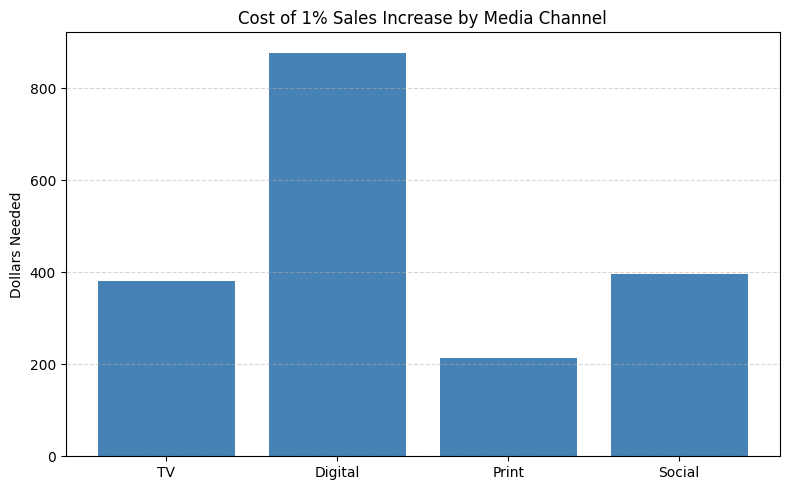

In [83]:
betas = {
    "TV": 0.0739,
    "Digital": 0.067,
    "Print": 0.0327,
    "Social": 0.0808
}

mean_spends = {
    "TV": 2624.129519230769,
    "Digital": 5450.636442307692,
    "Print": 597.5132692307692,
    "Social": 3010.5219230769235
}

costs = {
    channel: spend * (np.exp(0.01 / beta) - 1)
    for channel, (beta, spend) in zip(betas.keys(), zip(betas.values(), mean_spends.values()))
}

# Plot
plt.figure(figsize=(8, 5))
plt.bar(costs.keys(), costs.values(), color='steelblue')
plt.title("Cost of 1% Sales Increase by Media Channel")
plt.ylabel("Dollars Needed")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Interestingly, print advertising emerges as the cheapest way to increase sales by 1%, according to our model. This contrasts with typical real-world expectations but reflects the simulated data’s beta coefficients and spending distributions. It suggests diminishing returns in TV, digital, and social spends may have pushed those channels further along the saturation curve, making print spend relatively more efficient here.

# Summary and Next Steps

This project serves as a useful exercise in marketing mix modeling and Python-based regression analysis. The simulated dataset allowed controlled exploration of variable relationships and the impact of transformations.

Future extensions could incorporate:

-   Real-world messy data and associated cleaning challenges.

-   More complex models such as finite mixture models or nonlinear approaches.

-   Incorporation of interaction effects and consumer heterogeneity.